In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")

from collections import Counter, defaultdict
from itertools import count, chain
import random
import math

import dynet as dy
import numpy as np

from tqdm import tnrange, tqdm_notebook

In [2]:
# format of files: each line is "word1/tag2 word2/tag2 ..."
train_file="data/cleaned/train.BIEOU.tsv"
test_file="data/cleaned/dev.BIEOU.tsv"

MAX_LIK_ITERS = 3
SMALL_NUMBER = -1e10
MARGIN = 0


In [3]:
class Vocab:
    def __init__(self, w2i=None):
        if w2i is None: w2i = defaultdict(count(0).next)
        self.w2i = dict(w2i)
        self.i2w = {i:w for w,i in w2i.iteritems()}
    @classmethod
    def from_corpus(cls, corpus):
        w2i = defaultdict(count(0).next)
        for sent in corpus:
            [w2i[word] for word in sent]
        return Vocab(w2i)

    def size(self): 
        return len(self.w2i.keys())


In [4]:
def read(fname):
    """
    Read a NER-tagged file where each line is of the form "word1 tag2\nword2 tag2 ..."
    Yields lists of the form [(word1,tag1), (word2,tag2), ...]
    """
    with file(fname) as fh:
        sent = []
        for line in fh:
            line = line.strip()
            if line == "":
                if sent:
                    yield sent
                sent = []
                continue
            if line:
                line = tuple(line.split("\t"))
                sent.append(line)
    if sent:
        yield sent


In [5]:
train=list(read(train_file))
test=list(read(test_file))
print("Train: %s, Test: %s" % (len(train), len(test)))

Train: 2394, Test: 1000


In [6]:
print(train[0])

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]


In [7]:
words=[]
tags=[]
chars=set()
wc=Counter()
for sent in train:
    for w,p in sent:
        words.append(w)
        tags.append(p)
        chars.update(w)
        wc[w]+=1
words.append("_UNK_")
words.append("_S_")
tags.append("_S_")
chars.add("<*>")

In [8]:
vw = Vocab.from_corpus([words]) # TODO Vocab
vt = Vocab.from_corpus([tags])
vc = Vocab.from_corpus([chars])
UNK = vw.w2i["_UNK_"]
S_W = vw.w2i["_S_"]
S_T = vt.w2i["_S_"]

In [9]:
nwords = vw.size()
ntags  = vt.size()
nchars  = vc.size()

In [10]:
print(nwords, ntags, nchars)

(10588, 42, 93)


In [11]:
# DyNet Starts

model = dy.Model()
trainer = dy.AdamTrainer(model)

WORDS_LOOKUP = model.add_lookup_parameters((nwords, 64))
CHARS_LOOKUP = model.add_lookup_parameters((nchars, 20))
TRANS_LOOKUP = model.add_lookup_parameters((ntags, ntags))
p_t1  = model.add_lookup_parameters((ntags, 30))

# MLP on top of biLSTM outputs 100 -> 32 -> ntags
pH = model.add_parameters((32, 50*2))
pO = model.add_parameters((ntags, 32))

# word-level LSTMs
fwdRNN = dy.LSTMBuilder(1, 128, 50, model) # layers, in-dim, out-dim, model
bwdRNN = dy.LSTMBuilder(1, 128, 50, model)

# char-level LSTMs
cFwdRNN = dy.LSTMBuilder(1, 20, 32, model)
cBwdRNN = dy.LSTMBuilder(1, 20, 32, model)

In [12]:
def word_rep_backoff(w, cf_init, cb_init):
    if wc[w] > 5:
        w_index = vw.w2i[w]
        return WORDS_LOOKUP[w_index]
    else:
        pad_char = vc.w2i["<*>"]
        char_ids = [pad_char] + [vc.w2i[c] for c in w] + [pad_char]
        char_embs = [CHARS_LOOKUP[cid] for cid in char_ids]
        fw_exps = cf_init.transduce(char_embs)
        bw_exps = cb_init.transduce(reversed(char_embs))
        return dy.concatenate([ fw_exps[-1], bw_exps[-1] ])
    
    
def word_rep_all(w, cf_init, cb_init):
    if w in wc and wc[w] > 5:
        w_index = vw.w2i[w]
    else:
        w_index = UNK
    w_embed = WORDS_LOOKUP[w_index]
    ## Add char embeddings
    pad_char = vc.w2i["<*>"]
    char_ids = [pad_char] + [vc.w2i[c] for c in w] + [pad_char]
    char_embs = [CHARS_LOOKUP[cid] for cid in char_ids]
    fw_exps = cf_init.transduce(char_embs)
    bw_exps = cb_init.transduce(reversed(char_embs))
    return dy.concatenate([w_embed, fw_exps[-1], bw_exps[-1]])


In [13]:
def build_tagging_graph(words, word_rep=word_rep_backoff):
    dy.renew_cg()
    # parameters -> expressions
    H = dy.parameter(pH)
    O = dy.parameter(pO)

    # initialize the RNNs
    f_init = fwdRNN.initial_state()
    b_init = bwdRNN.initial_state()

    cf_init = cFwdRNN.initial_state()
    cb_init = cBwdRNN.initial_state()

    # get the word vectors. word_rep(...) returns a 128-dim vector expression for each word.
    wembs = [word_rep(w, cf_init, cb_init) for w in words]
    wembs = [dy.noise(we,0.1) for we in wembs] # optional

    # feed word vectors into biLSTM
    fw_exps = f_init.transduce(wembs)
    bw_exps = b_init.transduce(reversed(wembs))
# OR
#    fw_exps = []
#    s = f_init
#    for we in wembs:
#        s = s.add_input(we)
#        fw_exps.append(s.output())
#    bw_exps = []
#    s = b_init
#    for we in reversed(wembs):
#        s = s.add_input(we)
#        bw_exps.append(s.output())

    # biLSTM states
    bi_exps = [dy.concatenate([f,b]) for f,b in zip(fw_exps, reversed(bw_exps))]

    # feed each biLSTM state to an MLP
    exps = []
    for bi in bi_exps:
        r_t = O*(dy.tanh(H * bi))
        exps.append(r_t)

    return exps

In [14]:
def viterbi_decoding(vecs, gold_tags = []):
    # Initialize
    init_prob = [SMALL_NUMBER] * ntags
    init_prob[S_T] = 0
    for_expr = dy.inputVector(init_prob)
    best_ids = []
    trans_exprs = [TRANS_LOOKUP[tid] for tid in range(ntags)]
    # Perform the forward pass through the sentence
    for i, vec in enumerate(vecs):
        my_best_ids = []
        my_best_exprs = []
        for next_tag in range(ntags):
            # Calculate vector for single next tag
            next_single_expr = for_expr + trans_exprs[next_tag]
            next_single = next_single_expr.npvalue()
            # Find and save the best score
            my_best_id = np.argmax(next_single)
            my_best_ids.append(my_best_id)
            my_best_exprs.append(dy.pick(next_single_expr, my_best_id))
        # Concatenate the scores for all vectors together
        for_expr = dy.concatenate(my_best_exprs) + vec
        # Give a bonus to all but the correct tag if using margin
        if MARGIN != 0 and len(gold_tags) != 0:
            adjust = [MARGIN] * ntags
            adjust[vt.w2i[gold_tags[i]]] = 0
            for_expr = for_expr + dy.inputVector(adjust)
        # Save the best ids
        best_ids.append(my_best_ids)
    # Perform the final step to the sentence terminal symbol
    next_single_expr = for_expr + trans_exprs[S_T]
    next_single = next_single_expr.npvalue()
    my_best_id = np.argmax(next_single)
    best_expr = dy.pick(next_single_expr, my_best_id)
    # Perform the reverse pass
    best_path = [vt.i2w[my_best_id]]
    for my_best_ids in reversed(best_ids):
        my_best_id = my_best_ids[my_best_id]
        best_path.append(vt.i2w[my_best_id])
    best_path.pop() # Remove final <s>
    best_path.reverse()
    # Return the best path and best score as an expression
    return best_path, best_expr

def forced_decoding(vecs, tags):
    # Initialize
    for_expr = dy.scalarInput(0)
    for_tag = S_T
    # Perform the forward pass through the sentence
    for i, vec in enumerate(vecs): 
        my_tag = vt.w2i[tags[i]]
        for_expr = for_expr + dy.pick(TRANS_LOOKUP[my_tag], for_tag) + vec[my_tag]
        for_tag = my_tag
    for_expr = for_expr + dy.pick(TRANS_LOOKUP[S_T], for_tag)
    return for_expr

def viterbi_sent_loss(vecs, tags):
    #vecs = build_tagging_graph(words)
    viterbi_tags, viterbi_score = viterbi_decoding(vecs, tags)
    if viterbi_tags != tags:
        reference_score = forced_decoding(vecs, tags)
        return viterbi_score - reference_score
    else:
        return dy.scalarInput(0)

def sent_loss(vecs, tags):
    #vecs = build_tagging_graph(words)
    errs = []
    for v,t in zip(vecs,tags):
        tid = vt.w2i[t]
        err = dy.pickneglogsoftmax(v, tid)
        errs.append(err)
    return dy.esum(errs)

def tag_sent(vecs):
    #vecs = build_tagging_graph(words)
    vecs = [dy.softmax(v) for v in vecs]
    probs = [v.npvalue() for v in vecs]
    tags = []
    for prb in probs:
        tag = np.argmax(prb)
        tags.append(vt.i2w[tag])
    return tags

def predict(sent, viterbi=True, word_rep=word_rep_backoff):
    words = [w for w,t in sent]
    golds = [t for w,t in sent]
    vecs = build_tagging_graph(words, word_rep=word_rep)
    if viterbi:
        tags, loss_exp = viterbi_decoding(vecs)
    else:
        tags = tag_sent(vecs)
    return tags

def print_sequences(sequences, predictions, filename, test_data=False, notypes=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if notypes:
                    tag = tag[0]
                    p = p[0]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [15]:
num_tagged = cum_loss = 0
token_scores = []
sent_scores = []
avg_loss = []
word_rep=word_rep_all
for ITER in tnrange(50, desc="Iterations"):
    random.shuffle(train)
    for i,s in enumerate(tqdm_notebook(train, desc="Training Items", leave=False),1):
        if i % 500 == 0:
            trainer.status()
            avg_loss.append(cum_loss / num_tagged)
            cum_loss = 0
            num_tagged = 0
        if i % 10000 == 0 or i == len(train)-1: 
            good_sent = bad_sent = good = bad = 0.0
            for sent in tqdm_notebook(test, desc="Test instances", leave=False):
                words = [w for w,t in sent]
                golds = [t for w,t in sent]
                vecs = build_tagging_graph(words, word_rep=word_rep)
                if ITER < MAX_LIK_ITERS:
                    tags = tag_sent(vecs)
                else:
                    tags, loss_exp = viterbi_decoding(vecs)
                if tags == golds: good_sent += 1
                else: bad_sent += 1
                for go,gu in zip(golds,tags):
                    if go == gu: good += 1
                    else: bad += 1
            #print good/(good+bad), good_sent/(good_sent+bad_sent)
            token_scores.append(good/(good+bad))
            sent_scores.append(good_sent/(good_sent+bad_sent))
        # train on sent
        words = [w for w,t in s]
        golds = [t for w,t in s]
        vecs = build_tagging_graph(words, word_rep=word_rep)
        if ITER < MAX_LIK_ITERS:
            loss_exp =  sent_loss(vecs, golds)
        else:
            loss_exp =  viterbi_sent_loss(vecs, golds)
        cum_loss += loss_exp.scalar_value()
        num_tagged += len(golds)
        loss_exp.backward()
        trainer.update()
    #print "epoch %r finished" % ITER
    trainer.update_epoch(1.0)

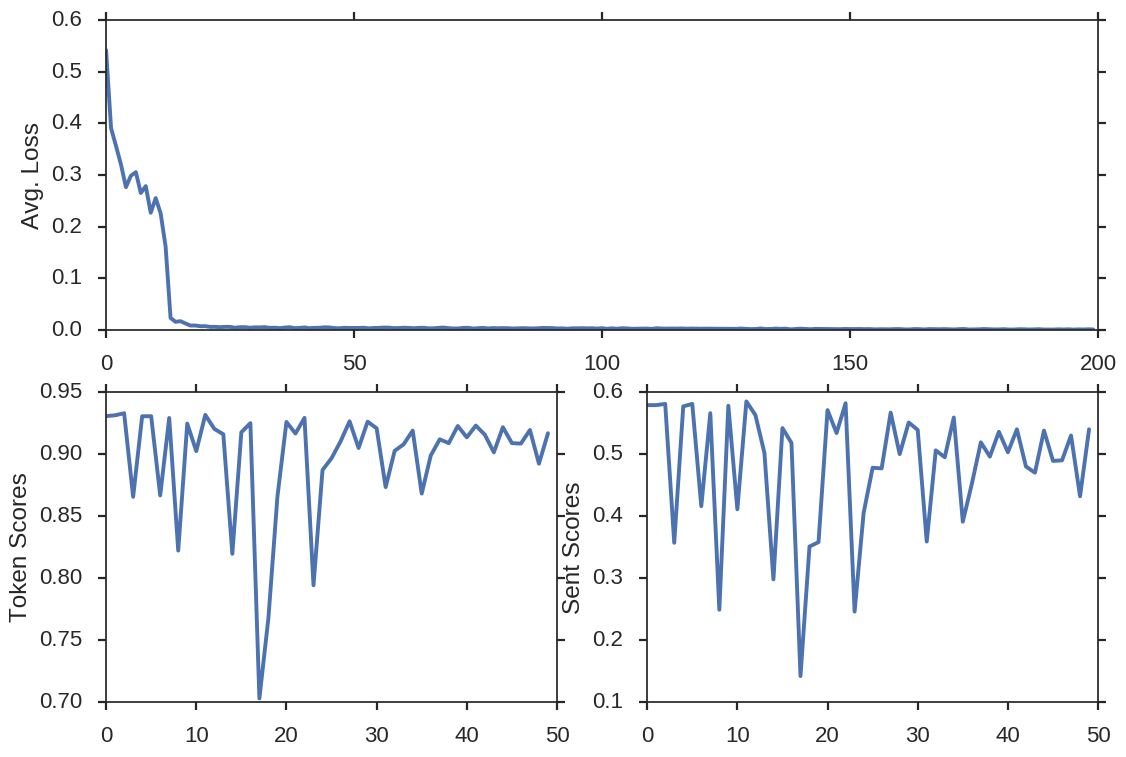

In [16]:
ax = plt.subplot2grid((2,2), (0,0), colspan=2)
ax.plot(avg_loss)
ax.set_ylabel("Avg. Loss")
ax = plt.subplot2grid((2,2), (1,0))
ax.plot(token_scores)
ax.set_ylabel("Token Scores")
ax = plt.subplot2grid((2,2), (1,1))
ax.plot(sent_scores)
ax.set_ylabel("Sent Scores")

In [17]:
zip(test[2], predict(test[2], word_rep=word_rep))

[(('RT', 'O'), 'O'),
 (('@shashiranjanttv', 'O'), 'O'),
 ((':', 'O'), 'O'),
 (('@shashiranjanttv', 'O'), 'O'),
 (('second', 'O'), 'O'),
 (('is', 'O'), 'O'),
 (('Bawana', 'U-geo-loc'), 'U-person'),
 (('constituency', 'O'), 'O'),
 (('on', 'O'), 'O'),
 (('Feb', 'O'), 'O'),
 (('4', 'O'), 'O'),
 (('-', 'O'), 'O'),
 (('Final', 'O'), 'O')]

In [18]:
print_sequences(test, [predict(s,word_rep=word_rep) for s in test], "test.dynet.tsv")

Done


In [19]:
! cat test.dynet.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 16261 tokens with 665 phrases; found: 556 phrases; correct: 104.
accuracy:  91.26%; precision:  18.71%; recall:  15.64%; FB1:  17.04
          company: precision:  26.09%; recall:  15.38%; FB1:  19.35  23
         facility: precision:  14.89%; recall:  17.95%; FB1:  16.28  47
          geo-loc: precision:  25.00%; recall:  24.14%; FB1:  24.56  112
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  6
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  58
            other: precision:  13.54%; recall:   9.85%; FB1:  11.40  96
           person: precision:  30.92%; recall:  27.49%; FB1:  29.10  152
          product: precision:   3.85%; recall:   2.70%; FB1:   3.17  26
       sportsteam: precision:   6.25%; recall:   2.86%; FB1:   3.92  32
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  4


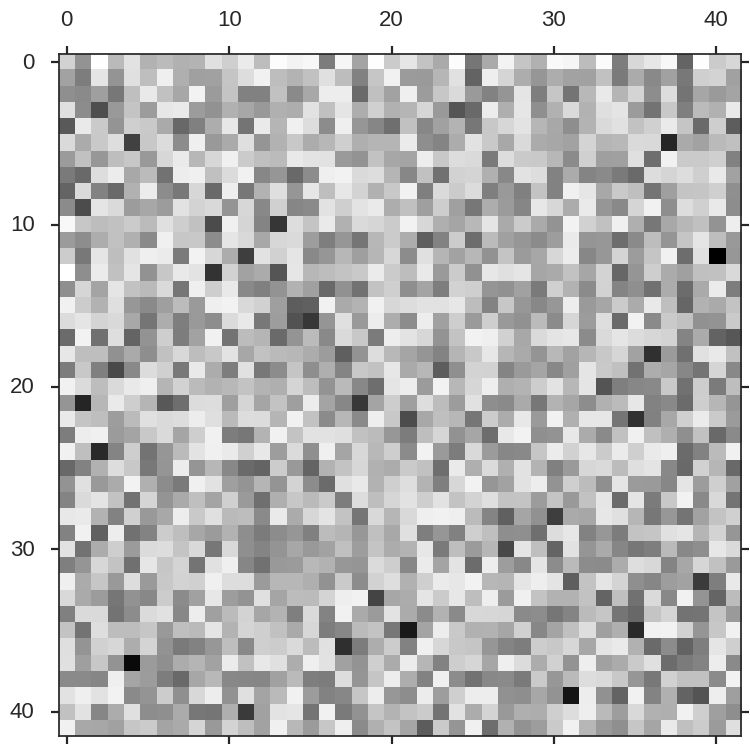

In [23]:
plt.matshow(TRANS_LOOKUP.as_array())

In [25]:
vt.i2w

{0: 'O',
 1: 'U-geo-loc',
 2: 'B-facility',
 3: 'E-facility',
 4: 'B-movie',
 5: 'E-movie',
 6: 'U-company',
 7: 'U-product',
 8: 'U-person',
 9: 'B-other',
 10: 'E-other',
 11: 'B-sportsteam',
 12: 'E-sportsteam',
 13: 'I-other',
 14: 'B-product',
 15: 'I-product',
 16: 'E-product',
 17: 'B-company',
 18: 'E-company',
 19: 'B-person',
 20: 'E-person',
 21: 'B-geo-loc',
 22: 'E-geo-loc',
 23: 'U-other',
 24: 'I-facility',
 25: 'U-sportsteam',
 26: 'U-tvshow',
 27: 'B-musicartist',
 28: 'E-musicartist',
 29: 'U-facility',
 30: 'I-musicartist',
 31: 'B-tvshow',
 32: 'E-tvshow',
 33: 'I-person',
 34: 'U-musicartist',
 35: 'I-geo-loc',
 36: 'I-company',
 37: 'I-movie',
 38: 'U-movie',
 39: 'I-tvshow',
 40: 'I-sportsteam',
 41: '_S_'}

In [28]:
sorted_ids = np.array([vt.w2i[t] for t in sorted(vt.i2w.values(), key=lambda x: x[2:] + x[:2])])
sorted_ids.shape

(42,)

In [33]:
TRANS_LOOKUP.as_array()[sorted_ids][:, sorted_ids].shape

(42, 42)

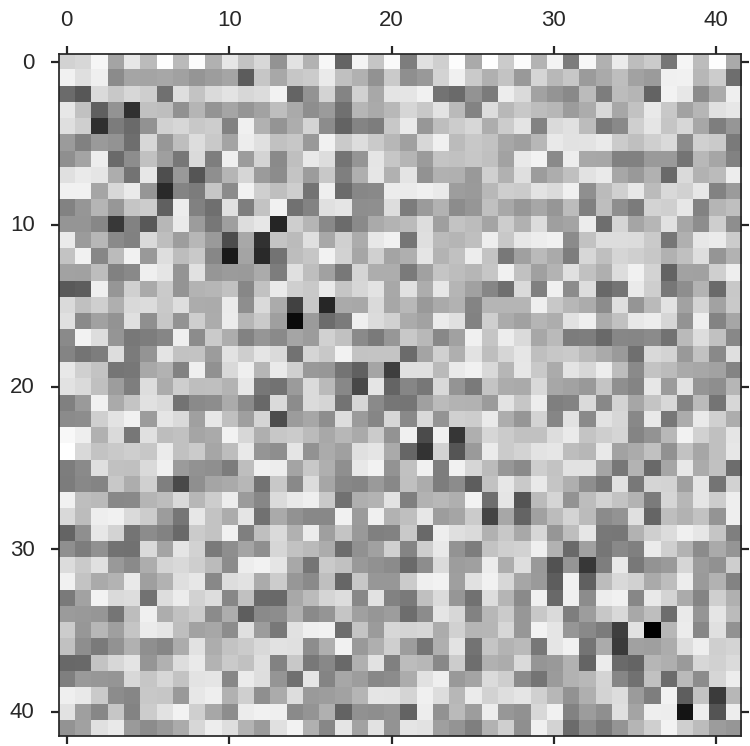

In [35]:
plt.matshow(TRANS_LOOKUP.as_array()[sorted_ids][:, sorted_ids])